# HR Analysis - Classification in Machine Learning

## Loading data

The dataset is downloaded from Kaggle at: https://www.kaggle.com/shivan118/hranalysis

This is a 50,000-row HR dataset, which we will use to predict an employee will be promoted or not.

We will use the data in `train.csv` file to build the most suitable model then predict the inputs given in `test.csv` for submission.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [5]:
df = pd.read_csv('train.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


## Data cleaning

Check if there are columns with missing values:

In [6]:
df.isna().sum()[df.isna().sum() > 0]

education               2409
previous_year_rating    4124
dtype: int64

Fill missing values in those 2 columns:

In [7]:
df['education'].mode()

0    Bachelor's
dtype: object

In [8]:
df['education'].fillna(df['education'].mode()[0], inplace=True)

In [9]:
df['previous_year_rating'].describe()

count    50684.000000
mean         3.329256
std          1.259993
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: previous_year_rating, dtype: float64

In [10]:
df['previous_year_rating'].fillna(df['previous_year_rating'].mean(), inplace=True)

In [11]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

## Exploratory Data Analysis and Visualization

Distributions of `department`, `education`, `age`:

In [12]:
px.histogram(df, x='department', title='Promoted per Department', color='is_promoted')

In [13]:
px.histogram(df, x='education', title='Promoted per Education', color='is_promoted')

In [15]:
px.histogram(df, x='age', title='Promoted per Age', color='is_promoted')

Relations between each numeric column and our target column:

In [16]:
df.groupby('is_promoted').mean()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
is_promoted,,,,,,,,
0,39187.520423,1.257639,34.844037,3.272542,5.879398,0.319685,0.014180,62.647686
1,39285.092331,1.203299,34.372965,3.938436,5.716367,0.698800,0.119751,71.325193


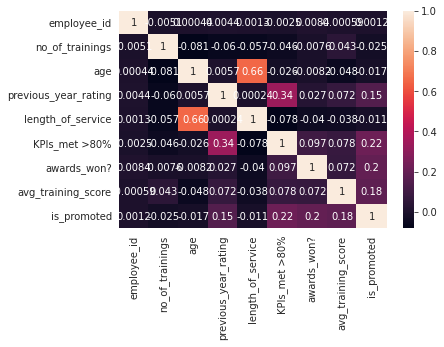

In [17]:
sns.heatmap(df.corr(), annot=True)

It turns out that `KPIs_met >80%` column is the most related to our target so maybe it is the most important feature of our future model. Let's see if we guess it right.

## Preprocessing

In [18]:
inputs = df.drop(['employee_id', 'is_promoted'], axis=1).copy()
targets = df['is_promoted']

inputs.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73


### Scaling Numeric Features

In [19]:
numeric_cols = inputs.select_dtypes(include=np.number).columns.tolist()

inputs[numeric_cols].describe()


,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750
std,0.609264,7.660169,1.211661,4.265094,0.477590,0.150450,13.371559
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000


In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

inputs[numeric_cols] = scaler.fit_transform(inputs[numeric_cols])

inputs[numeric_cols].describe().loc[['min', 'max']]

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Encoding Categorical Features

In [21]:
categorical_cols = inputs.select_dtypes('object').columns.tolist()

inputs[categorical_cols].nunique()

department              9
region                 34
education               3
gender                  2
recruitment_channel     3
dtype: int64

In [22]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

encoder.fit(inputs[categorical_cols])

encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])

inputs = inputs.drop(categorical_cols, axis=1).copy()

inputs.head()


,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,0.000000,0.375,1.0,0.194444,1.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.250,1.0,0.083333,0.0,0.0,0.350000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.000000,0.350,0.5,0.166667,0.0,0.0,0.183333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.111111,0.475,0.0,0.250000,0.0,0.0,0.183333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.000000,0.625,0.5,0.027778,0.0,0.0,0.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Sample split

Due to hardware limits, we will split our training data into `X`, `y` for hyperparameters tuning and `train_X`, `train_y` for cross-validation with `1:9` ratio.

In [23]:
from sklearn.model_selection import train_test_split

train_X, X, train_y, y = train_test_split(inputs, targets, test_size=0.1, random_state=42)

## Modelling

We will examine a couple of diffirent models to see which model is the best for our data.

We will choose the "winner" based on their average cross-validation scores and the distribution of those scores, which are captured by `scores_avg` list `scores` dict respectively.

For each model, we use `GridSearchCV` to choose the best parameters for that model, then we validate the model result by using `cross_val_score`.

In [24]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

scores = {}
scores_avg = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [70]:
solver = ['newton-cg', 'lbfgs', 'liblinear']
C = [100, 10, 1.0, 0.1, 0.01]

param_grid = dict(solver=solver, C=C)

gs = GridSearchCV(LogisticRegression(), 
                  param_grid, 
                  n_jobs=-1, 
                  cv=cv, 
                  scoring='accuracy'
                  )

gs.fit(X, y)

print(f"Best params: {gs.best_params_}")

# Best params: {'C': 100, 'solver': 'newton-cg'}

Best params: {'C': 100, 'solver': 'newton-cg'}


In [26]:
logistic = LogisticRegression(C=100, solver='newton-cg')

score = cross_val_score(logistic, train_X, train_y, cv=cv, scoring='accuracy')
scores_avg.append(('LogisticRegression', score.mean()))
scores['LogisticRegression'] = score

print(f"Accuracy: {score.mean() * 100:.2f}% (+/- {score.std() * 100:.2f}%)")

Accuracy: 93.14% (+/- 0.11%)


### Ridge Classifier

In [27]:
from sklearn.linear_model import RidgeClassifier

In [74]:
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

param_grid = dict(alpha=alpha)

gs = GridSearchCV(RidgeClassifier(), 
                  param_grid, 
                  n_jobs=-1, 
                  cv=cv, 
                  scoring='accuracy'
                  )

gs.fit(X, y)

print(f"Best params: {gs.best_params_}")

# Best params: {'alpha': 0.1}

Best params: {'alpha': 0.1}


In [28]:
ridge = RidgeClassifier(alpha=0.1)

score = cross_val_score(ridge, train_X, train_y, cv=cv, scoring='accuracy')
scores_avg.append(('RidgeClassifier', score.mean()))
scores['RidgeClassifier'] = score

print(f"Accuracy: {score.mean() * 100:.2f}% (+/- {score.std() * 100:.2f}%)")

Accuracy: 92.60% (+/- 0.05%)


### K-Nearest Neighbors

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [77]:
n_neighbors = [3, 5, 7, 9, 11]
metric = ['euclidean', 'manhattan', 'minkowski']

param_grid = dict(n_neighbors=n_neighbors, metric=metric)

gs = GridSearchCV(KNeighborsClassifier(), 
                  param_grid, 
                  n_jobs=-1, 
                  cv=cv, 
                  scoring='accuracy'
                  )

gs.fit(X, y)

print(f"Best params: {gs.best_params_}")

# Best params: {'metric': 'euclidean', 'n_neighbors': 9}

Best params: {'metric': 'euclidean', 'n_neighbors': 9}


In [30]:
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=9)

score = cross_val_score(knn, train_X, train_y, cv=cv, scoring='accuracy')
scores_avg.append(('KNeighborsClassifier', score.mean()))
scores['KNeighborsClassifier'] = score

print(f"Accuracy: {score.mean() * 100:.2f}% (+/- {score.std() * 100:.2f}%)")

Accuracy: 91.37% (+/- 0.06%)


### Support Vector Machine

In [31]:
from sklearn.svm import SVC

In [80]:
kernel = ['poly', 'rbf', 'sigmoid']
C = [10, 1.0, 0.1, 0.01]

param_grid = dict(kernel=kernel, C=C)

gs = GridSearchCV(SVC(), 
                  param_grid, 
                  n_jobs=-1, 
                  cv=cv, 
                  scoring='accuracy'
                  )

gs.fit(X, y)

print(f"Best params: {gs.best_params_}")

# Best params: {'C': 1.0, 'kernel': 'poly'}

Best params: {'C': 1.0, 'kernel': 'poly'}


In [32]:
svm = SVC(C=1.0, kernel='poly')

score = cross_val_score(svm, train_X, train_y, cv=cv, scoring='accuracy')
scores_avg.append(('SupportVectorMachine', score.mean()))
scores['SupportVectorMachine'] = score

print(f"Accuracy: {score.mean() * 100:.2f}% (+/- {score.std() * 100:.2f}%)")

Accuracy: 93.16% (+/- 0.09%)


### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [84]:
max_depth = [5, 10, 15, 20, 25]

param_grid = dict(max_depth=max_depth)

gs = GridSearchCV(DecisionTreeClassifier(), 
                  param_grid, 
                  n_jobs=-1, 
                  cv=cv, 
                  scoring='accuracy'
                  )

gs.fit(X, y)

print(f"Best params: {gs.best_params_}")

# Best params: {'max_depth': 5}

Best params: {'max_depth': 5}


In [34]:
dtree = DecisionTreeClassifier(max_depth=5)

score = cross_val_score(dtree, train_X, train_y, cv=cv, scoring='accuracy')
scores_avg.append(('DecisionTree', score.mean()))
scores['DecisionTree'] = score

print(f"Accuracy: {score.mean() * 100:.2f}% (+/- {score.std() * 100:.2f}%)")

Accuracy: 92.49% (+/- 0.06%)


### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
n_estimators = [100, 200, 400, 800]
max_depth = [5, 10, 15, 20, 25]

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

gs = GridSearchCV(RandomForestClassifier(), 
                  param_grid, 
                  n_jobs=-1, 
                  cv=cv, 
                  scoring='accuracy'
                  )

gs.fit(X, y)

print(f"Best params: {gs.best_params_}")

# Best params: {'max_depth': 25, 'n_estimators': 400}

Best params: {'max_depth': 25, 'n_estimators': 400}


In [36]:
rf = RandomForestClassifier(max_depth=25, n_estimators=400)

score = cross_val_score(rf, train_X, train_y, cv=cv, scoring='accuracy')
scores_avg.append(('RandomForest', score.mean()))
scores['RandomForest'] = score

print(f"Accuracy: {score.mean() * 100:.2f}% (+/- {score.std() * 100:.2f}%)")

Accuracy: 93.47% (+/- 0.13%)


### Gradient Boosting

In [37]:
from xgboost import XGBClassifier

In [90]:
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [100, 200, 400, 800]
max_depth = [5, 10, 15, 20, 25]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

gs = GridSearchCV(XGBClassifier(), 
                  param_grid, 
                  n_jobs=-1, 
                  cv=cv, 
                  scoring='accuracy'
                  )

gs.fit(X, y)

print(f"Best params: {gs.best_params_}")

# Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800}

Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800}


In [38]:
gbm = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=800)

score = cross_val_score(gbm, train_X, train_y, cv=cv, scoring='accuracy')
scores_avg.append(('GradientBoosting', score.mean()))
scores['GradientBoosting'] = score

print(f"Accuracy: {score.mean() * 100:.2f}% (+/- {score.std() * 100:.2f}%)")

Accuracy: 94.01% (+/- 0.16%)


## Choosing model

In [39]:
scores_avg_df = pd.DataFrame(scores_avg, columns=['Model', 'Avg Score'])

px.line(scores_avg_df, x='Model', y='Avg Score')

In [40]:
scores_df = pd.DataFrame(scores)

px.box(scores_df)

So `GradientBoosting`, which is `gbm`, will be our "winner" model with highest average cross-validation scores `94.01%` and better distribution of those scores.

We'll check the assumption we made about the feature importances.

In [41]:
gbm.fit(train_X, train_y)

importance_df = pd.DataFrame({
    'feature': inputs.columns,
    'importance': gbm.feature_importances_
}).sort_values('importance', ascending=False)

importance_df.head()

,feature,importance
4,KPIs_met >80%,0.156856
14,department_Sales & Marketing,0.101702
12,department_Procurement,0.094806
11,department_Operations,0.087411
6,avg_training_score,0.056071


Text(0.5, 1.0, 'Feature Importances')

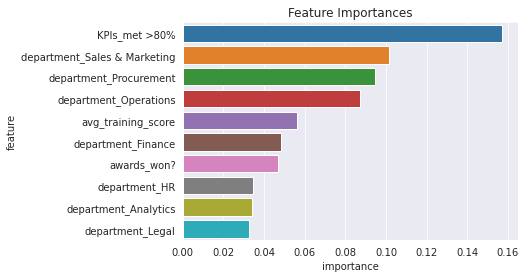

In [42]:
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importances')

It turns out `KPIs_met >80%` is the most important feature to our model as we guessed.

## Saving the model

We save our model into a `joblib` file to predict the test inputs and for future use.

In [43]:
import joblib

In [44]:
hr_model = {
    'model': gbm,
    'scaler': scaler,
    'encoder': encoder,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(hr_model, 'hr_model.joblib')

['hr_model.joblib']

## Making predictions for Test Set

Load the data from the test set.

In [45]:
test_df = pd.read_csv('test.csv')

test_df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


Load the model we saved.

In [46]:
import joblib

hr_model = joblib.load('hr_model.joblib')

hr_model

{'categorical_cols': ['department',
  'region',
  'education',
  'gender',
  'recruitment_channel'],
 'encoded_cols': ['department_Analytics',
  'department_Finance',
  'department_HR',
  'department_Legal',
  'department_Operations',
  'department_Procurement',
  'department_R&D',
  'department_Sales & Marketing',
  'department_Technology',
  'region_region_1',
  'region_region_10',
  'region_region_11',
  'region_region_12',
  'region_region_13',
  'region_region_14',
  'region_region_15',
  'region_region_16',
  'region_region_17',
  'region_region_18',
  'region_region_19',
  'region_region_2',
  'region_region_20',
  'region_region_21',
  'region_region_22',
  'region_region_23',
  'region_region_24',
  'region_region_25',
  'region_region_26',
  'region_region_27',
  'region_region_28',
  'region_region_29',
  'region_region_3',
  'region_region_30',
  'region_region_31',
  'region_region_32',
  'region_region_33',
  'region_region_34',
  'region_region_4',
  'region_region_5',
 

Preprocess the data from test set.

In [47]:
test_df['education'].fillna(test_df['education'].mode()[0], inplace=True)
test_df['previous_year_rating'].fillna(test_df['previous_year_rating'].mean(), inplace=True)

numeric_cols = hr_model['numeric_cols']
categorical_cols = hr_model['categorical_cols']

scaler = hr_model['scaler']
encoder = hr_model['encoder']

test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
test_df[encoded_cols] = encoder.transform(test_df[categorical_cols])

test_X = test_df[numeric_cols + encoded_cols]

Make predictions using our chosen 
model.

In [48]:
model = hr_model['model']

test_preds = model.predict(test_X)

Make submission.

In [49]:
submission_df = pd.DataFrame()

submission_df['employee_id'] = test_df['employee_id']
submission_df['is_promoted'] = test_preds

submission_df.to_csv('submission.csv', index=False)

## Summary

We've done the following works through this notebook:

1. Downloading then loading the data.
2. Cleaning the data.
3. Performing a brief analysis and visualization to gather insights about the data.
4. Preprocessing the data including feature engineering and splitting the data.
5. Training some models and tuning hyper parameters of each model.
6. Choosing the best model and saving it.
7. Making predictions for the test set to submit.

## References


1. [Jovian's Zero to GBMs Machine Learning Course](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms)
2. [scikit-learn Documentation](https://scikit-learn.org/0.21/documentation.html)